## CSC 466 - Final Report

### Team Members: Killian Brait and Nick Ambrose<hr>

### Introduction

In this report, we'll examine a dataset of divorce data that includes the answers to 54 relationship-therapy-related questions.

In [4]:
import pandas as pd

# Load the dataset
data = pd.read_csv('data/divorce_data.csv', sep=';')

# Print the first 5 rows
data.head()

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,...,Q46,Q47,Q48,Q49,Q50,Q51,Q52,Q53,Q54,Divorce
0,2,2,4,1,0,0,0,0,0,0,...,2,1,3,3,3,2,3,2,1,1
1,4,4,4,4,4,0,0,4,4,4,...,2,2,3,4,4,4,4,2,2,1
2,2,2,2,2,1,3,2,1,1,2,...,3,2,3,1,1,1,2,2,2,1
3,3,2,3,2,3,3,3,3,3,3,...,2,2,3,3,3,3,2,2,2,1
4,2,2,1,1,1,1,0,0,0,0,...,2,1,2,3,2,2,2,1,0,1


### Data Analysis

Exploring the dataset to see what we should do when modeling to gain the most knowledge out of this dataset.

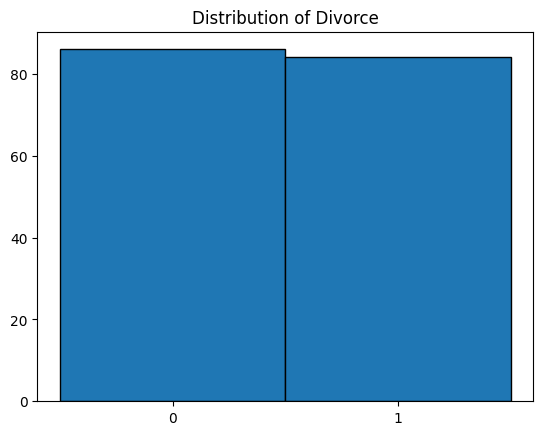

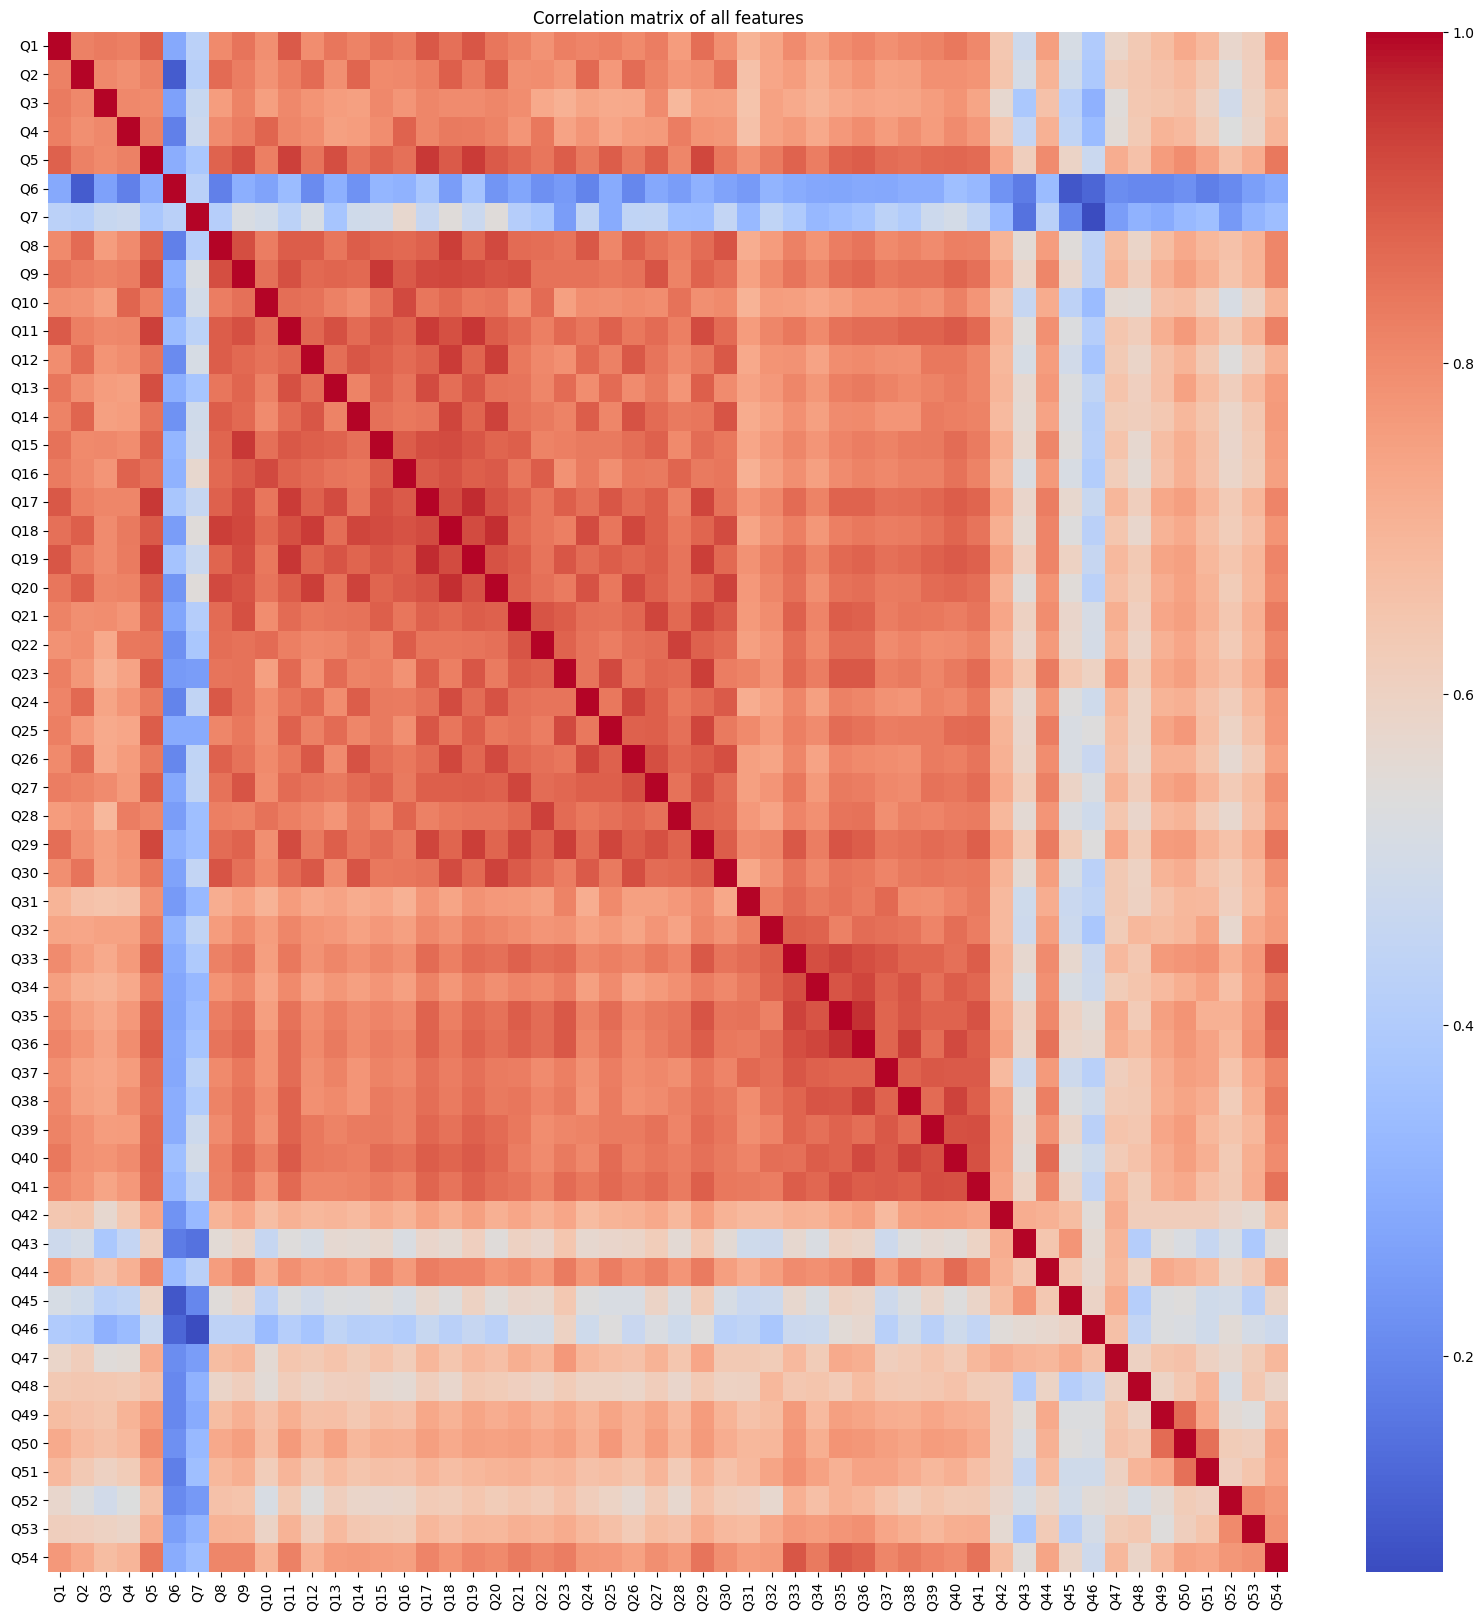

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

features = data.drop('Divorce', axis=1, inplace=False)
target = data['Divorce']

# Check the distribution of the target variable (Divorce)
plt.hist(data['Divorce'], bins=[-0.5, 0.5, 1.5], edgecolor='black')
plt.xticks([0,1])
plt.title('Distribution of Divorce')
plt.show()

# Check the correlation of the features
corr_matrix = features.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, cmap='coolwarm')
plt.title("Correlation matrix of all features")
plt.show()

This data analysis shows us two very important things.

1. The dataset is balanced, there are a similar number of positive and negative classes, which means that the model will not be biased towards one class.
2. Many features are highly correlated with each other, which means that we can reduce the number of features without losing much information. This is what we'll do next.

### Dimensionality Reduction

### Clustering

First, we'll use the Elbow method to find an optimal K value for our K-Means clustering algorithm. We'll be using two different K-Means clustering algorithms, one implemented by scikit-learn and the other implemented by the team members themselves. We'll compare these two algorithms to see if there are any differences in the results.

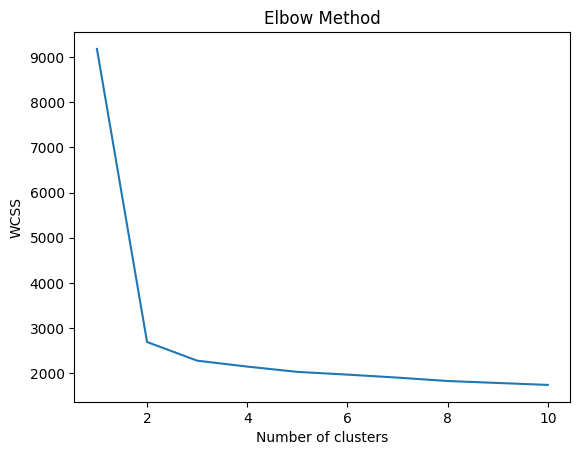

In [14]:
# Elbow Method

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Standardize the features to have mean = 0 and variance = 1
scaler = StandardScaler()
features_standardized = scaler.fit_transform(features)

wcss = []
max_clusters = 10
for i in range(1, max_clusters+1):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(features_standardized)
    wcss.append(kmeans.inertia_)

# Plotting the results onto a line graph, allowing us to observe 'The elbow'
plt.plot(range(1, max_clusters+1), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS') # Within cluster sum of squares
plt.show()

Three (3) appears to be the optimal K value for K-Means clustering on this dataset.

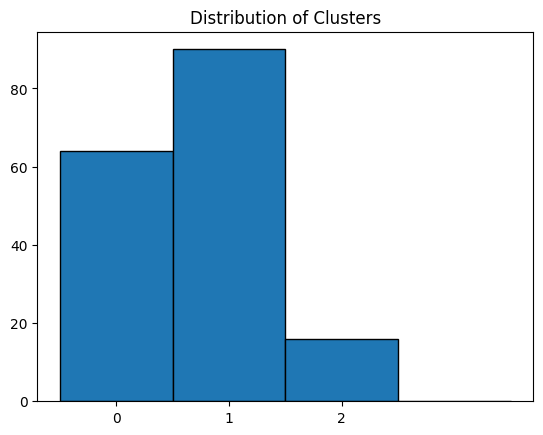

In [19]:
# Apply k-means with the optimal number of clusters determined
optimal_clusters = 3
kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)
clusters = kmeans.fit_predict(features_standardized)

# Add the cluster labels to our DataFrame
data_with_clusters = features.copy()
data_with_clusters['Cluster'] = clusters

# Visualize the distribution of clusters
plt.hist(data_with_clusters['Cluster'], bins=range(optimal_clusters+2), align='left', edgecolor='black')
plt.xticks(range(optimal_clusters))
plt.title('Distribution of Clusters')
plt.show()


Now, we'll analyze each cluster by looking at the average values of the responses for each question in each cluster. With this we will get a sense of the characteristics that define our three clusters.

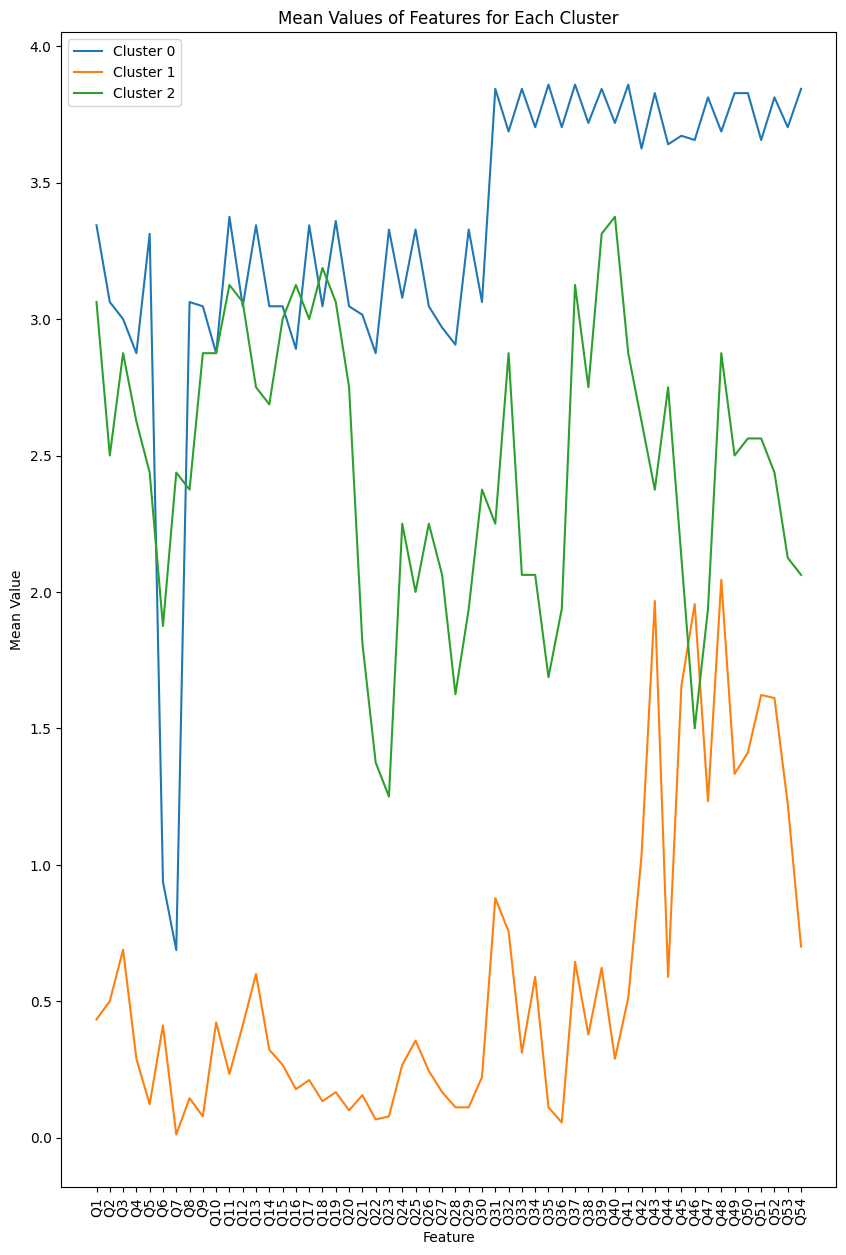

In [20]:
# Calculate the mean values for each cluster
cluster_means = data_with_clusters.groupby('Cluster').mean()

# Transpose the DataFrame for easier plotting
cluster_means = cluster_means.transpose()

# Plot the mean values for each cluster
plt.figure(figsize=(10,15))
for i in range(optimal_clusters):
    plt.plot(cluster_means[i], label=f'Cluster {i}')
plt.legend()
plt.title('Mean Values of Features for Each Cluster')
plt.xlabel('Feature')
plt.ylabel('Mean Value')
plt.xticks(rotation=90)
plt.show()


Now we can start to understand our three clusters.

- Cluster 0: This cluster has significantly higher averages than the other clusters for questions 21-54, showing that respondents in this cluster were far more likely to answer 3s or 4s on the questions, indicating that they "Frequently" or "Always" agreed with the question. Although, it should be noted that for the initial questions 1-20, this cluster had very similar averages to cluster 2.

- Cluster 1: This cluster had significantly lower averages for almost all the questions, showing that respondents in this cluster were far more likely to answer 0s or 1s on the questions, indicating that they "Never" or "Rarely" agreed with the question. Although, it should be noted that for question 46 this cluster had a higher average than cluster 2.

- Cluster 2: This cluster is the median group. They had averages that typically fell in between the other two clusters. In this cluster, respondents where likely to answer 1s, 2s, or 3s on the questions, indicating that they "Seldom", "Averagely", or "Frequently" agreed with the question. It should be noted that for questions 6, 7, 10, 12, 16, and 18 this cluster had a higher average than cluster 0, indeed for these questions this cluster had the highest average.

In conclusion, without even looking at the questions to see what was asked, we can conclude that cluster 0 was the most likely to answer extremely in the affirmative, cluster 1 was most likely to answer extremely in the negative, and cluster 2 was the median group. Let's move on to see how these cluster's are related to happy marriages and divorces.

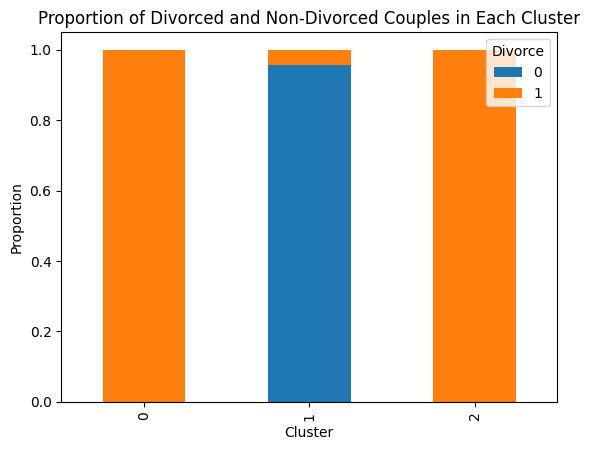

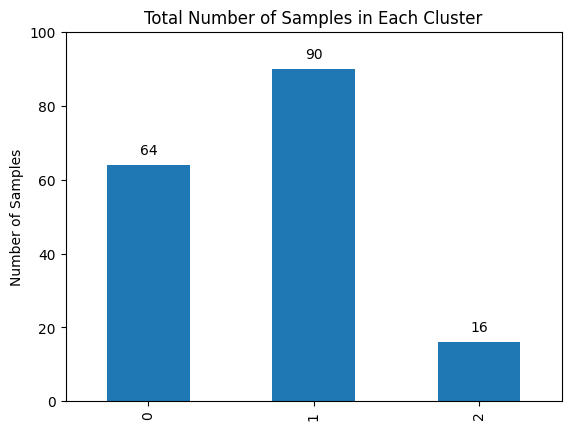

In [26]:
## Now we'll look at the proportions in each cluster

# Add the 'Divorce' column back into the DataFrame
data_with_clusters['Divorce'] = data['Divorce']

# Calculate the proportion of divorced and non-divorced couples in each cluster
divorce_proportions = data_with_clusters.groupby('Cluster')['Divorce'].value_counts(normalize=True)

# Convert the multi-index series to a DataFrame and reset the index
divorce_proportions = divorce_proportions.to_frame()
divorce_proportions.columns = ['Proportion']
divorce_proportions.reset_index(inplace=True)

# Create a pivot table for easier plotting
divorce_pivot = divorce_proportions.pivot(index='Cluster', columns='Divorce', values='Proportion')

# Plot the proportions of divorced and non-divorced couples in each cluster
divorce_pivot.plot(kind='bar', stacked=True)
plt.title('Proportion of Divorced and Non-Divorced Couples in Each Cluster')
plt.ylabel('Proportion')
plt.show()

# Calculate the total number of samples in each cluster
cluster_counts = data_with_clusters['Cluster'].value_counts().sort_index()

# Plot the total number of samples in each cluster
ax = cluster_counts.plot(kind='bar')
plt.title('Total Number of Samples in Each Cluster')
plt.ylabel('Number of Samples')
plt.ylim(0, cluster_counts.max() + 10)  # Increase ylim

# Label the exact number of samples on the count chart
for i, v in enumerate(cluster_counts):
    ax.text(i, v + 2, str(v), ha='center', va='bottom')

plt.show()


Aha! Now we can see some very interesting things. Both cluster's 0 and 2 have a 100% divorce rate. Looking back we can see that this may mean that if you answer the questions in the affirmative most of the time, then you are likely in a relationship that will end in divorce. However, this is based on averages, so there are likely some people that answered a few questions very differently that the rest of the group. 

It's also important to take note of the value counts in each cluster, shown by the second graph above. The dataset is still balanced, even though two cluster's have a 100% divorce rate, they are smaller clusters. Taking this into account, we can likely ignore the predictive power of cluster 2 since it has only 16 samples, or 25% of cluster 0's size. Additionally, cluster 2 is our median group, so it's small and the median, meaning it's likely just a random group of samples that were outliers in the other two clusters.

This leads to a clear conclusion, if you answer the questions in the affirmative most of the time, then you are likely in a relationship that will end in divorce. However, if you answer the questions in the negative most of the time, then you are likely in a relationship that will not end in divorce. This is a very interesting result, and it's likely that this is a strong predictor of divorce.